In [854]:
from quat_routines import world2body, quaternion_product, quat2so3, quat2euler, conjugate


##### Model

##### Parameters

In [855]:
# parameters
import numpy as np
from math import cos, sin, tan

I_x = 0.16
I_y = 0.16
I_z = 0.16

X_du = -5.5
Y_dv = -12.7
Z_dw = -14.57
N_dr = -0.12
M_dq = -0.12
K_dp = -0.12

X_u = -4.03
Y_v = -6.22
Z_w = -5.18
K_p = -0.07
M_q = -0.07
N_r = -0.07

X_uu = -18.18
Y_vv = -21.66
Z_ww = -36.99
K_pp = -1.55
M_qq = -1.55
N_rr = -1.55

m = 11.5
g = 9.8

W = 112.8  # m*g
B = 114.8  # rho*g*V
z_g = 0.02


##### Sympy

In [856]:
# Symbolic Jacobian calculations

# from sympy import *

# phi, theta, psi = symbols('\phi, \\theta, \psi')

# Rz = Matrix([[cos(psi), -sin(psi), 0],
#                    [sin(psi), cos(psi), 0],
#                    [0, 0, 1]])
# Ry = Matrix([[cos(theta), 0 , sin(theta)],
#                    [0, 1, 0],
#                    [-sin(theta), 0, cos(theta)]])
# Rx = Matrix([[1, 0, 0],
#                    [0 , cos(phi), -sin(phi)],
#                    [0, sin(phi), cos(phi)]])
# R = Rz@Ry@Rx
# T = Matrix([[1, sin(phi)*tan(theta), cos(phi)*tan(theta)],
#                    [0, cos(phi), - sin(phi)],
#                    [0, sin(phi)/cos(theta), cos(phi)/cos(theta)]])

# p, e1, e2, e3 = symbols('\eta, \epsilon_1, \epsilon_2, \epsilon_3')

# R = Matrix([[1-2*(e2**2 + e3**3),2*(e2*e1 - e3*p),2*(e1*e3 - e2*p)],
#             [2*(e2*e1 - e3*p),1-2*(e1**2 + e3**2),2*(e2*e3 - e1*p)],
#             [2*(e1*e3 - e2*p),2*(e2*e3 - e1*p),1-2*(e1**2 + e2**2)]])
# T = 0.5*Matrix([[-e1, -e2, -e3],
#                 [p, -e3, e2],
#                 [e3, p, -e1],
#                 [-e2, e1, p]])


In [857]:
# J = Matrix(BlockMatrix([[R, zeros(3, 3)], [zeros(4, 3), T]]))
# J


##### Dynamics

In [858]:
def J(X):
    x, y, z, p, e1, e2, e3 = X
    return np.array([[-2*e2**2-2*e3**2+1, 2*e1*e2-2*e3*p, 2*e1*e3-2*e2*p, 0, 0, 0],
                     [2*e1*e2-2*e3*p, -2*e1**2-2*e3**2 +
                         1, -2*e1*p + 2*e2*e3, 0, 0, 0],
                     [2*e1*e3-2*e2*p, -2*e1*p + 2*e2 *
                         e3, -2*e1**2-2*e2**2+1, 0, 0, 0],
                     [0, 0, 0, -0.5*e1, -0.5*e2, -0.5*e3],
                     [0, 0, 0, 0.5*p, -0.5*e3, 0.5*e2],
                     [0, 0, 0, 0.5*e3, 0.5*p, -0.5*e1],
                     [0, 0, 0, -0.5*e2, 0.5*e1, 0.5*p]])


In [859]:
M_rb = np.array([[m, 0, 0, 0, m*z_g, 0],
                 [0, m, 0, -m*z_g, 0, 0],
                 [0, 0, m, 0, 0, 0],
                 [0, -m*z_g, 0, I_x, 0, 0],
                 [m*z_g, 0, 0, 0, I_y, 0],
                 [0, 0, 0, 0, 0, I_z]])

M_a = -np.diag([X_du, Y_dv, Z_dw, K_dp, M_dq, N_dr])

M = M_rb + M_a
M_inv = np.linalg.inv(M)


In [860]:
def C_rb(vel):
    u, v, w, p, q, r = vel
    return np.array([[0, 0, 0, 0, m*w, 0],
                     [0, 0, 0, -m*w, 0, 0],
                     [0, 0, 0, m*v, -m*u, 0],
                     [0, m*w, -m*v, 0, I_z*r, -I_y*q],
                     [-m*w, 0, -m*u, -I_z*r, 0, I_x*p],
                     [m*v, -m*u, 0, I_y*q, -I_x*p, 0]])


def C_a(vel):
    u, v, w, p, q, r = vel
    return np.array([[0, 0, 0, 0, Z_dw*w, 0],
                     [0, 0, 0, -Z_dw*w, 0, -X_du*u],
                     [0, 0, 0, -Y_dv*v, X_du*u, 0],
                     [0, -Z_dw*w, Y_dv*v, 0, -N_dr*r, M_dq*q],
                     [Z_dw*w, 0, -X_du*u, N_dr*r, 0, -K_dp*p],
                     [-Y_dv*v, X_du*u, 0, -M_dq*q, K_dp*p, 0]])


def C(v):
    return C_rb(v) + C_a(v)


In [861]:
def D(vel):
    vel = np.abs(vel)
    u, v, w, p, q, r = vel
    return -np.diag([X_u + X_uu*u, Y_v + Y_vv*v, Z_w + Z_ww*w,
                     K_p + K_pp*p, M_q + M_qq*q, N_r + N_rr*r])


def g_(X):
    x, y, z, p, e1, e2, e3 = X
    return np.array([(B-W)*(2*e1*e3 - 2*e2*p),
                     (B-W)*(2*e2*e3 - 2*e1*p),
                     (W-B)*(2*e1**2 + 2*e2**2 - 1),
                     z_g*W*(2*e2*e3 + 2*e1*p),
                     z_g*W*(2*e1*e3 - 2*e2*p),
                     0])


##### System

In [862]:
def f(X, t, u):
    x, v = X[:7], X[7:]
    
    x[3:] = x[3:] / np.linalg.norm(x[3:])

    dx = J(x)@v

    dv = -M_inv@(C(v)@v + D(v)@v + g_(x) - u)

    dX = dx.tolist()
    dX.extend(dv)

    return dX


##### Simulation

In [863]:
from scipy.integrate import odeint


def simulate(f, control, X_0, X_d, t_0=0, t_f=10, N=1000):

    t = np.linspace(t_0, t_f, N)
    dT = (t_f - t_0)/N
    x_sol = []
    u_sol = []
    x0 = X_0
    u0 = np.array(control(x0, 0, X_d))

    x_sol = np.zeros((N, len(x0)))
    u_sol = np.zeros((N, len(u0)))

    for i in range(N):
        time = t[i]
        t_k = np.linspace(time, time+dT, 2)
        u = control(x0, time, X_d)
        x_k = odeint(f, x0, t_k, args=(u, ))
        x0 = x_k[-1]
        x_sol[i, :] = x0
        u_sol[i, :] = u

    return x_sol, u_sol, t


In [864]:
from matplotlib.pyplot import *


def plot_graphs(f, control, init_state, X_d):

    x_sol, u_sol, t = simulate(f, control, init_state, X_d)

    plot(t, x_sol[:, :3], label=['x', 'y', 'z'])

    ylabel(r'Output $y$')
    xlabel(r'Time $t$ (s)')
    grid(color='black', linestyle='--', linewidth=1.0, alpha=0.3)
    legend(loc='lower right')
    grid(True)
    tight_layout()
    show()

    angles = [quat2euler(q) for q in x_sol[:, 3:7]]

    plot(t, angles, label=['phi', 'theta', 'psi'])

    ylabel(r'Output $y$')
    xlabel(r'Time $t$ (s)')
    grid(color='black', linestyle='--', linewidth=1.0, alpha=0.3)
    legend(loc='lower right')
    grid(True)
    tight_layout()
    show()

    plot(t, x_sol[:, 7:], label=['dx', 'dy', 'dz', 'dphi', 'dtheta', 'dpsi'])

    ylabel(r'Output $dy$')
    xlabel(r'Time $t$ (s)')
    grid(color='black', linestyle='--', linewidth=1.0, alpha=0.3)
    legend(loc='lower right')
    grid(True)
    tight_layout()
    show()

    plot(t, u_sol, label=['u_x', 'u_y', 'u_z', 'u_phi', 'u_theta', 'u_psi'])

    ylabel(r'Control $y$')
    xlabel(r'Time $t$ (s)')
    grid(color='black', linestyle='--', linewidth=1.0, alpha=0.3)
    legend(loc='lower right')
    grid(True)
    tight_layout()
    show()


##### Control

In [865]:
def zero_control(X, t):
    return [0, 0, 0, 0, 0, 0]


In [866]:
from simple_pid import PID


def so3_error(quaternion, desired_quaternion):
    conjugated_quaternion = conjugate(quaternion)
    q_err = quaternion_product(desired_quaternion, conjugated_quaternion)
    so3_error = quat2so3(q_err)
    return so3_error


pids = [PID(1, 0.001, 0.0),
        PID(1, 0.001, 0.0),
        PID(1.2, 0.001, 0.0)]

p_gain = np.diag([3, 2, 5])
d_gain = np.diag([2, 1, 3])


def pd_torque(x, x_d, v):

    tau = []

    for i in range(3):
        tau.append(pids[i](x[i]))

    orientation_error = so3_error(x[3:], x_d[3:])
    omega = np.array(v[3:])
    body_torque = p_gain @ orientation_error - d_gain @ omega
    tau.extend(body_torque)

    return tau


In [867]:
L = 1


def model_based_pid(X, t, x_d):

    x, v = X[:7], X[7:]

    e_b = J(x).T@(np.array(x) - np.array(x_d))
    v_r = L*e_b
    a_r = -L*np.array(v)

    tau_m = M@a_r + C(v)@v + D(v)@v_r + g_(x)
    tau_pid = M@pd_torque(x, x_d, v)

    return tau_pid + tau_m


def inverse_dynamics(X, t, x_d):

    x, v = X[:7], X[7:]

    a = pd_torque(x, x_d, v)

    tau_m = M@a + C(v)@v + D(v)@v + g_(x)

    return tau_m


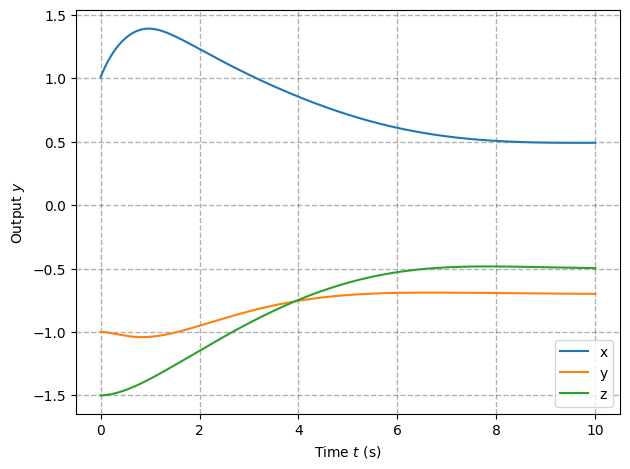

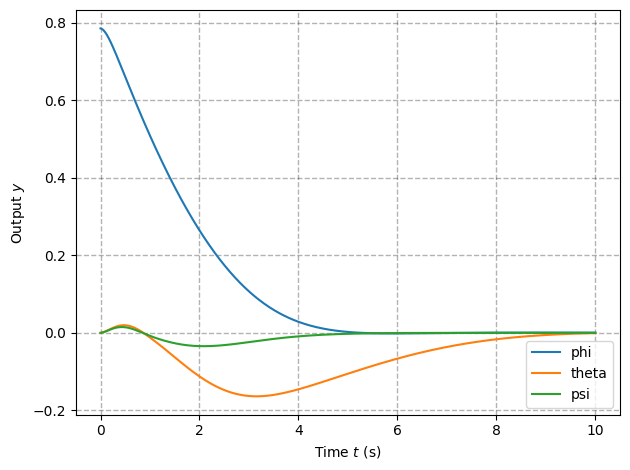

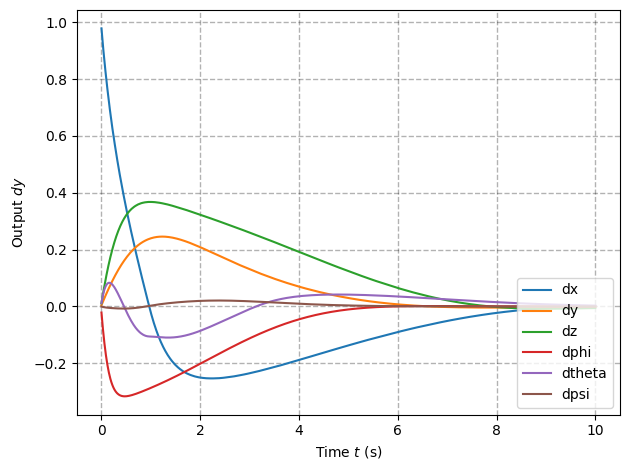

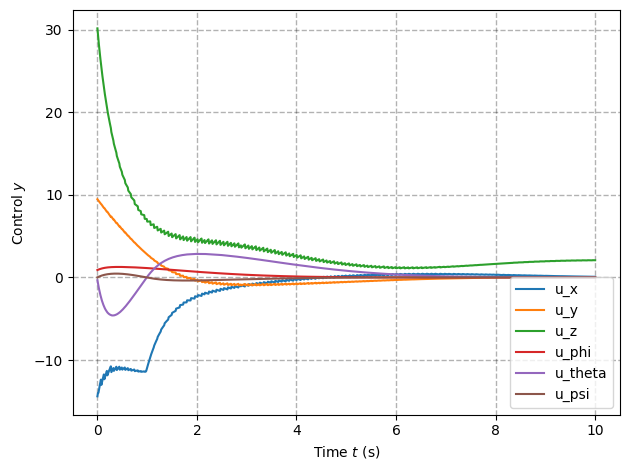

In [869]:
X_0 = [1, -1, -1.5, 0.9238795, 0.3826834, 0, 0,  1, 0, 0, 0, 0, 0]

X_d = [0.5, -0.7, -0.5, 1, 0, 0, 0]

for i in range(3):
        pids[i].reset()
        pids[i].setpoint = X_d[i]

plot_graphs(f, model_based_pid, X_0, X_d)
